## Import Libraries 

In [1]:
import numpy as np # to handle matrix and data operation


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torch.autograd import Variable

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision

import PIL.Image as Image
import io
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Load data

We use MNIST data for training and evaluation

In [3]:
data_raw = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Label: 5


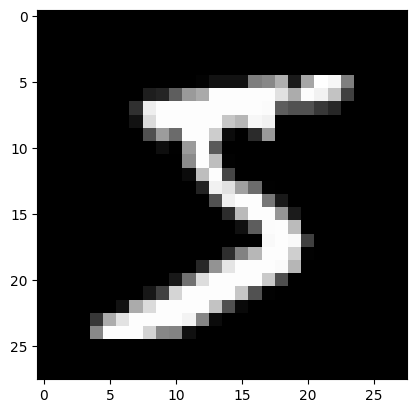

In [4]:
image,label = data_raw[0]
plt.imshow(image[0,:,:], cmap = 'gray')
print("Label:", label)

In [5]:
data1 = []
for i in data_raw:
    data1.append((i[0],i[1]))


## Preprocess data

Enrich data by removing black pixel (padding) around the digit pictures

After remove padding, remember to resize the image to 28x28

In [6]:
def remove_padding(img):
    
    non_zero_rows = torch.any(img[0] != 0, dim=1)
    non_zero_cols = torch.any(img[0] != 0, dim=0)

    a1 = torch.arange(28)
    a2 = torch.arange(28)
    a1=a1[non_zero_rows]
    a2=a2[non_zero_cols]

    img = img[:,a1[0]:a1[-1]+1,a2[0]:a2[-1]+1]
    img = torchvision.transforms.Resize((28,28))(img)
    return img
    

In [7]:
data2 = []
for i in data_raw:
    img = i[0]
    img = remove_padding(img)
    data2.append((img,i[1]))
index = 0



Image after removing padding:


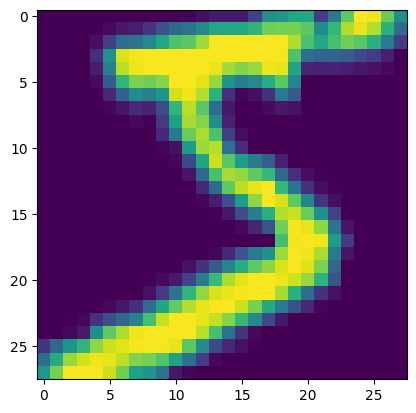

In [8]:
index = 0
print("Image after removing padding:")
plt.imshow(data2[0][0][0])


Enrich data by adding black pixel (padding) around the digit pictures

After remove padding, remember to resize the image to 28x28

In [9]:
def add_padding(img, padding = 7):
    img = F.pad(img, pad = (padding, padding, padding, padding), value = 0)
    img = torchvision.transforms.Resize((28,28))(img)
    return img

In [10]:
data3 = []
for i in data_raw:
    img = i[0]
    img = add_padding(img)
    data3.append((img,i[1]))

Image after removing padding:


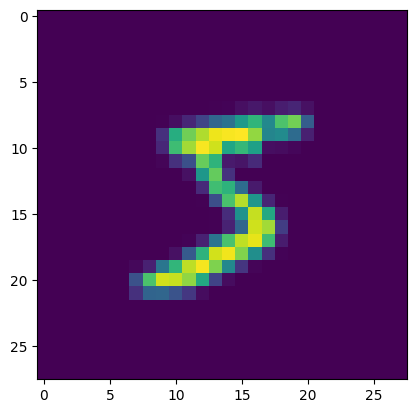

In [11]:
index = 0
print("Image after adding padding:")
plt.imshow(data3[0][0][0])


In [12]:
print(len(data1))
print(len(data2))
print(len(data3))
data = data1+data2+data3 
print(len(data))

60000
60000
60000
180000


In [13]:
train, test = random_split(data, [144000, 36000])
BATCH_SIZE = 64
## Print the length of train and validation datasets
print("Length of Train Datasets: ", len(train))
print("Length of Test Datasets: ", len(test))

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = True)


Length of Train Datasets:  144000
Length of Test Datasets:  36000


## Convolutional Neural Network (CNN)

We use CNN for model of digit recognition

In [119]:



class CNN(nn.Module):
    
    def __init__(self, device = 'cpu'):
        super(CNN, self).__init__()
        
        self.device = device

        self.layers = nn.Sequential()

        self.layers.append(nn.Conv2d(1,32,kernel_size=5, padding=2, stride=1, device=self.device))
        self.layers.append(nn.AvgPool2d(2))
        self.layers.append(nn.LeakyReLU(0.01))
        self.layers.append(nn.Conv2d(32,64,kernel_size=5, padding=2, stride=1, device=self.device))
        self.layers.append(nn.Dropout(p=0.3))
        self.layers.append(nn.LeakyReLU(0.01))
        self.layers.append(nn.AvgPool2d(2))
        self.layers.append(nn.Conv2d(64,128,kernel_size=5, padding=2, stride=1, device=self.device))
        self.layers.append(nn.LeakyReLU(0.01))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(7*7*128, 512, device=self.device))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=0.3))
        self.layers.append(nn.Linear(512, 10, device=self.device))

        self.loss = nn.CrossEntropyLoss()
    
    def forward(self,x):
        return self.layers(x)

    def predict(self,x):
        y_pred = F.softmax(self.forward(x))
        return torch.max(y_pred,1)[1]
    

def fit(model, data, device = 'cpu'):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    EPOCHS = 10
    model.train()

    for e in range(EPOCHS):
        correct = 0
        for i, (x_batch,y_batch) in enumerate(data):
            x = Variable(x_batch).float().to(device)
            y = Variable(y_batch).to(device)
        
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            predicted = torch.max(y_pred,1)[1]
            correct += (predicted == y).sum()
            if i % 50 == 0:
                print("{:<15} {:<15} {:<30} {:<30}".format("Epoch: " + str(e), "| Batch: " + str(i), "| Loss: " + str(loss.item()), "| accuracy: " + str(float(correct/float(BATCH_SIZE*(i+1))))))
 



#cnn.forward(image)

## Train Model

In [120]:
print("Training on", device)
cnn = CNN(device=device)
fit(cnn,train_loader,device)

Training on cuda
Epoch: 0        | Batch: 0      | Loss: 2.3032491207122803     | accuracy: 0.08984375        
Epoch: 0        | Batch: 50     | Loss: 0.40125149488449097    | accuracy: 0.6662837266921997
Epoch: 0        | Batch: 100    | Loss: 0.21454888582229614    | accuracy: 0.7876701354980469
Epoch: 0        | Batch: 150    | Loss: 0.15562695264816284    | accuracy: 0.8378518223762512
Epoch: 0        | Batch: 200    | Loss: 0.1535792201757431     | accuracy: 0.8664684295654297
Epoch: 0        | Batch: 250    | Loss: 0.15024027228355408    | accuracy: 0.8852558732032776
Epoch: 0        | Batch: 300    | Loss: 0.1488032042980194     | accuracy: 0.8978664875030518
Epoch: 0        | Batch: 350    | Loss: 0.12413226813077927    | accuracy: 0.9079082012176514
Epoch: 0        | Batch: 400    | Loss: 0.05587427690625191    | accuracy: 0.9155626893043518
Epoch: 0        | Batch: 450    | Loss: 0.08558519929647446    | accuracy: 0.9215025305747986
Epoch: 0        | Batch: 500    | Loss: 0.0

After training, we save the model

In [121]:
torch.save(cnn.state_dict(), './model/mnist-cnn.pth')

## Evaluate Model

In [122]:
def eval(model, test, device = 'cpu'):
    model.eval()
    correct = 0
    for x,y in test:
        x = x.unsqueeze(0)
        y_pred = model.predict(x.to(device))
        if(y_pred == y):
            correct += 1
    return correct / len(test)


In [123]:
print(eval(cnn,test,device))

C:\Users\Trung\AppData\Local\Temp\ipykernel_8332\1562697807.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(self.forward(x))


0.9926944444444444
